# Imports classiques
Nous allons tout d'abord lancer les imports classiques

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import Optim as opt
import functions as func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Vous devez copier-coller ici votre algorithme de descente de Wolfe ainsi que `ls_wolfe_step_is_one`

In [11]:
def ls_wolfe(x,function,step,descent,f,df) :
    e1 = 1e-4
    e2 = 0.9
    sl = 0
    sh = 10000
    step2 = step
    while True:
        if function.value(x + step2*descent) > f + e1*step2*np.dot(df,descent):
            sh = step2
            step2 = (sl + sh)/2
        elif np.dot(function.grad(x+step2*descent),descent) < e2*np.dot(df,descent):
            sl = step2
            if sh < 10000:
                step2 = (sl + sh)/2
            else:
                step2 = 2*step2
        else:
            x2 = step2*descent + x
            f2 = function.value(x2)
            df2 = function.grad(x2)
            return x2,f2,df2,step2
    
def ls_wolfe_step_is_one(x,function,step,descent,f,df) :
    return ls_wolfe(x,function,1.,descent,f,df)


## L-BFGS
Nous allons nous intéresser à l'algorithme Limited Memory BFGS. Cet algorithme est du type BFGS, c'est à dire qu'il estime l'inverse de la Hessienne de $f$. Le L dans le nom de l'algorithme signifie qu'il est à mémoire limitée, c'est à dire qu'il ne garde en mémoire que les $L$ dernières itérations de calcul pour estimer la Hessienne.
L'algorithme est le suivant : Nous sommes à l'itération $k$, nous notons $x_k$ l'itéré et nous avons stocké les vecteurs suivants pour tout $k_{min}\le i\le k$.
$$ s_i=x_{i}-x_{i-1} \text{ et } y_i=\nabla f(x_{i}) -\nabla f(x_{i-1})$$
Et on a aussi stocké $\rho_i=\frac{1}{(s_i,y_i)}$. Tous les $\rho_i$ doivent être positifs.
L'algorithme est le suivant 

\begin{align*}
r &\gets -\nabla f(x_k) \\
\text{pour } i &= k, k-1, \dots, k_{\min} \\
&\quad \alpha_i \gets \rho_i \,(s_i \cdot r) \\
&\quad r \gets r - \alpha_i y_i \\
r &\gets \frac{s_{k_{\min}} \cdot y_{k_{\min}}}{y_{k_{\min}} \cdot y_{k_{\min}}} \, r \\
\text{pour } i &= k_{\min}, \dots, k \\
&\quad \beta_i \gets \rho_i \,(y_i \cdot r) \\
&\quad r \gets r + (\alpha_i - \beta_i) s_i \\
\text{retourner } &r
\end{align*}





# Fonctions sur les listes
Vous aurez sans doute besoin des fonctions suivantes pour les listes

In [12]:
a=[(2*i,3*i) for i in range(5) ]
print(a)
print(a[3],a[-1])
print('*** Pop ***')
a.pop(0)
print(a)
print('*** Parcours ***')
for e,f in a :
      print(e,'et',f)
print('*** Parcours Inverse***')
for e in reversed(a) :
      print(e)
b=[e**2 for e,f in a]
print(b)
print('*** Parcours de deux listes ensembles***')
for (m,(t,p)) in zip(b,a) :
    print(m,'et',t,'et encore',p)
print('*** Append ***')
print(b)
b.append(546)
print(b)
print('*** Inversion ***')
c=list(reversed(b))
print(c)
print(len(b))

[(0, 0), (2, 3), (4, 6), (6, 9), (8, 12)]
(6, 9) (8, 12)
*** Pop ***
[(2, 3), (4, 6), (6, 9), (8, 12)]
*** Parcours ***
2 et 3
4 et 6
6 et 9
8 et 12
*** Parcours Inverse***
(8, 12)
(6, 9)
(4, 6)
(2, 3)
[4, 16, 36, 64]
*** Parcours de deux listes ensembles***
4 et 2 et encore 3
16 et 4 et encore 6
36 et 6 et encore 9
64 et 8 et encore 12
*** Append ***
[4, 16, 36, 64]
[4, 16, 36, 64, 546]
*** Inversion ***
[546, 64, 36, 16, 4]
5


# Class BFGS
Créez une classe `BFGS` ci dessous, sa fonction `__init__` sera de la forme 
`__init__(self,nb_stock_max=8)` où `nb_stock_max` est le nombre maximum d'itérations prises en compte. Cette fonction créera aussi une liste vide appelée `stock` qui conserve les $s_i,g_i,\rho_i$. Elle devra aussi créer une liste vide nommée `last_iter`.

In [13]:
class BFGS() :
    def __init__(self,nb_stock_max=8,verbose=True) :
        self.nb_stock_max = nb_stock_max
        self.stock = []
        self.last_iter = None

    def push(self, x, g):
        if self.last_iter is not None:
            s = x - self.last_iter[0]
            y = g - self.last_iter[1]
            rho = 1/np.dot(s,y)
            if rho > 0:
                if len(self.stock) == self.nb_stock_max:
                    self.stock.pop(0)
                self.stock.append((s,y,rho))
            else:
                self.stock = []
        self.last_iter=(x,g)

    def dc(self,x,function,df) :
        self.push(x,df)
        return self.get(df)
    
    def get(self, grad) :
        # 1
        r = -grad
        Lalpha = []
        # 2
        if len(self.stock) > 0:
            for i in range(len(self.stock)-1,-1,-1):
                # a
                s = self.stock[i][0]
                y = self.stock[i][1]
                rho = self.stock[i][2]
                alpha = rho*np.dot(s,r)
                Lalpha.append(alpha)
                # b
                r = r - alpha*y
            #3
            Lalpha = Lalpha[::-1]
            #4
            r = (np.dot(s,y)/np.dot(y,y))*r
            #5
            for i in range(0,len(self.stock)):
                #a
                beta = self.stock[i][2]*np.dot(self.stock[i][1],r)
                #b
                r = r + (Lalpha[i] - beta)*self.stock[i][0]
        return r                 

# Push
Nous allons maintenant créer une fonction `push(self, x, grad)` qui enregistre $s_k,g_k,\rho_k$. Pour cela, on a besoin de $x_{k-1},\nabla f(x_{k-1})$. Si ils existent, ils se trouvent dans la liste `self.last_iter`. Ensuite on peut calculer $s_k,g_k$ et $\rho_k$. 

Si $\rho_k$ est positif, alors on enregistre le triplet $(s_k,g_k,\rho_k)$ à la fin de la liste `self.stock`, en vérifiant `self.stock` ne doit contenir au maximum que les dernières `self.nb_stock_max` itérations (si nécessaire on retire le tout premier élément de `self.stock`). 

Si $\rho_k$ est négatif, quelquechose c'est mal passé, on vide le `self.stock`.

A la fin, on n'oublie pas de mettre $x_{k}$ et $\nabla f(x_{k})$ dans `self.last_iter` pour être sûr de les y trouver la prochaine fois.

# Get

Nous allons maintenant créer une fonction `get(self, grad)` qui modifie la direction de descente et applique l'algorithme ci-dessus. Cette fonction doit nous rendre le `r` final. Si le `self.stock` est vide, cette fonction doit nous rendre `-grad`

# dc

Nous créeons maintenant une fonction `dc(self,x,function,df)` qui appplique tout d'abord `self.push` puis `self.get`, elle rend le résultat de la fonction de `self.get`.

# C'est l'heure de tester ...
Lancez une méthode de Newton_Wolfe sur votre fonction préférée et à chaque itération calculez ce que donnerait un L-BFGS. Comparez les angles des directions entre la méthode de Newton et le L-BFGS, comparez aussi le ration des normes. Ensuite lancez un LBFGS avec recherche de pas de Wolfe sur vos tests préférez et obtenez le comportement de Newton_Wolfe sans le calcul de la Hessienne...

iter=   0 f=-4.030e-02 df=9.589e-01 comp=[   1,   1,   0]
iter=   1 f=-3.876e-01 df=4.552e-01 comp=[   3,   3,   0]
iter=   2 f=-4.787e-01 df=2.055e-01 comp=[   5,   5,   0]
iter=   3 f=-4.990e-01 df=4.415e-02 comp=[   7,   7,   0]
iter=   4 f=-5.000e-01 df=3.843e-03 comp=[   9,   9,   0]
iter=   5 f=-5.000e-01 df=8.867e-05 comp=[  11,  11,   0]
Success !!! Algorithm converged !!!


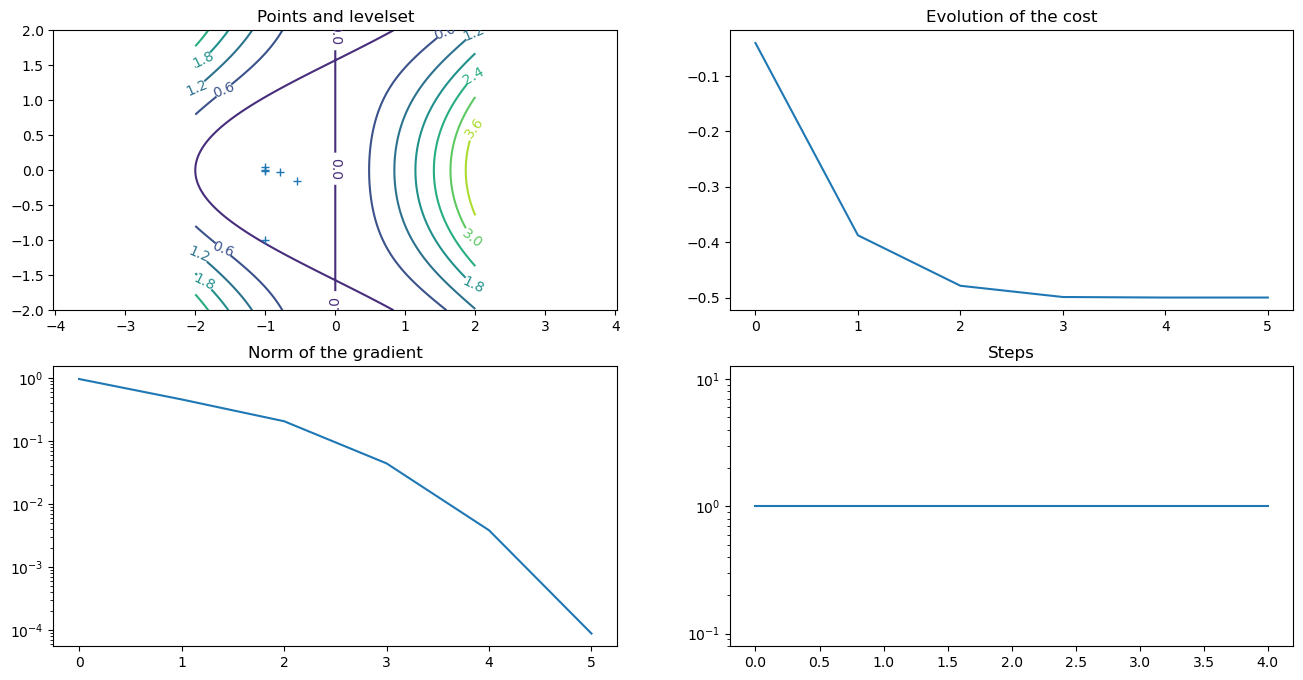

iter :  52 cost :2.880e-13 grad :2.119e-05 comp=[ 131, 107,   0]


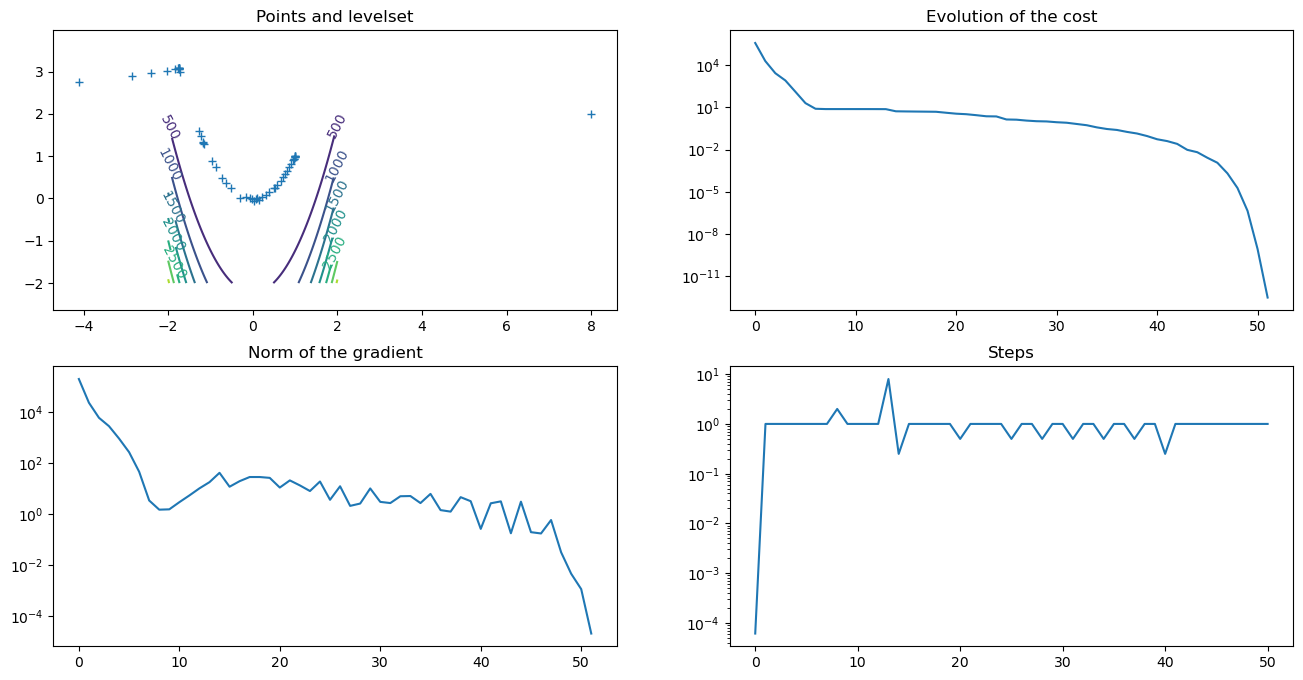

In [14]:
f=func.oscill()
x0=np.array([-1,-1])
B=BFGS()
res=opt.main_algorithm(f,0.1,x0,ls=ls_wolfe_step_is_one,dc=B.dc,verbose=True)
opt.graphical_info(res,f)


f=func.Rosen()
x0=np.array([8,2])
B=BFGS()
res=opt.main_algorithm(f,1,x0,ls=ls_wolfe_step_is_one,dc=B.dc,verbose=False)
print("iter : {:3d} cost :{:1.3e} grad :{:1.3e} comp=[{:4d},{:4d},{:4d}]"
      .format(len(res['list_costs']),res['list_costs'][-1],res['list_grads'][-1],f.nb_eval,f.nb_grad,f.nb_hess))
opt.graphical_info(res,f)

iter :  25 cost :4.379e-11 grad :7.989e-05 comp=[  62,  51,   0]


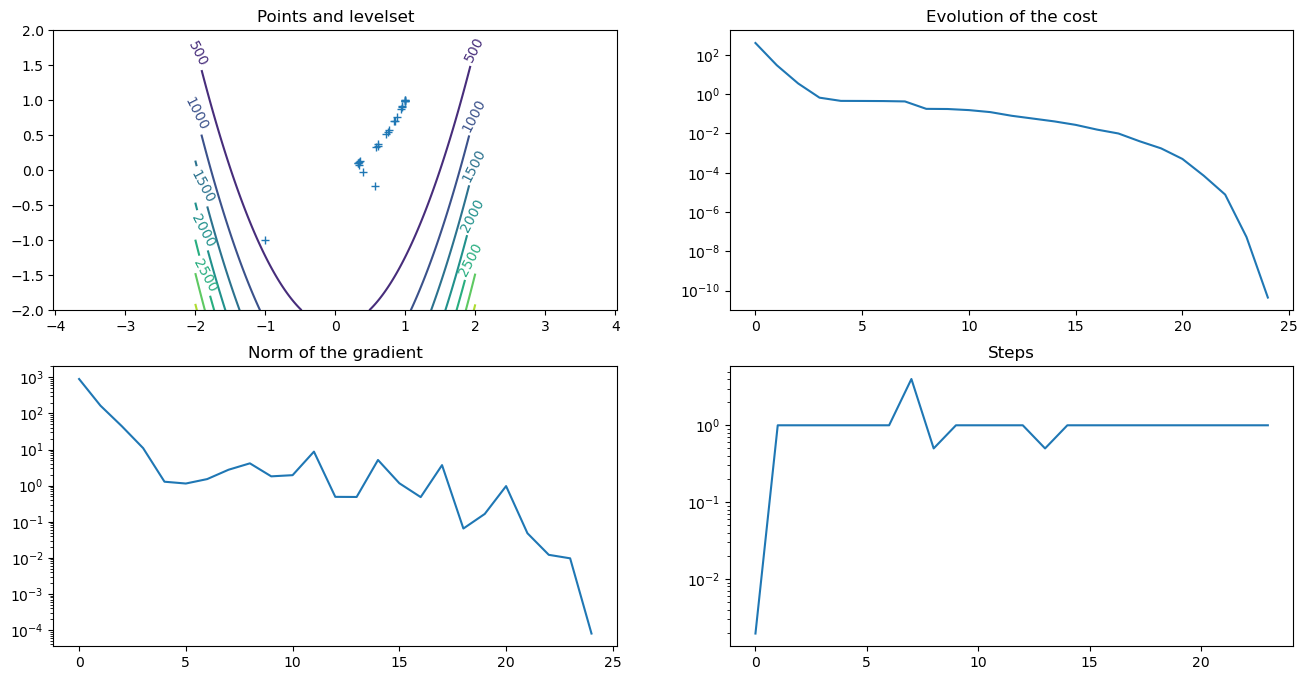

In [15]:
f=func.Rosen()
x0=np.array([-1,-1])
B=BFGS()
res=opt.main_algorithm(f,1,x0,ls=ls_wolfe_step_is_one,dc=B.dc,verbose=False)
print("iter : {:3d} cost :{:1.3e} grad :{:1.3e} comp=[{:4d},{:4d},{:4d}]"
      .format(len(res['list_costs']),res['list_costs'][-1],res['list_grads'][-1],f.nb_eval,f.nb_grad,f.nb_hess))
opt.graphical_info(res,f)

## Comparaison
Votre objectif est de regarder la documentation de `scipy.optimize`, de comprendre le code suivant et de comparer votre algorithme de BFGS+Wolfe avec les algorithmes disponibles dans scipy.optimize

In [16]:
f=func.Rosen()
x0=np.array([-1,-1])
from scipy.optimize import minimize
res=minimize(f.value,x0,jac=f.grad,tol=1.e-4)
#pas de constraints données donc par défaut minimize utilise Wolfe + BFGS

In [17]:
print(res)
print(f.nb_eval,f.nb_grad)
#success : True donc convergence
#mais plus d'itérations (39 > 25) donc notre L-BFGS est mieux

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.650426969757865e-13
        x: [ 1.000e+00  1.000e+00]
      nit: 30
      jac: [-2.660e-05  1.292e-05]
 hess_inv: [[ 5.004e-01  1.000e+00]
            [ 1.000e+00  2.003e+00]]
     nfev: 39
     njev: 39
39 39
